# Stock Forecasting using pmdarima (Quasi Seasonal)

https://github.com/alkaline-ml/pmdarima

In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima import arima
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing

import yfinance as yf
yf.pdr_override()

In [2]:
stock = 'AMD' # input
start = '2017-01-01' # input 
end = '2021-11-08'  # input
df = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,11.42,11.65,11.02,11.43,11.43,55182000
2017-01-04,11.45,11.52,11.24,11.43,11.43,40781200
2017-01-05,11.43,11.69,11.23,11.24,11.24,38855200
2017-01-06,11.29,11.49,11.11,11.32,11.32,34453500
2017-01-09,11.37,11.64,11.31,11.49,11.49,37304800


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-01,119.449997,125.669998,118.129997,125.230003,125.230003,54559800
2021-11-02,124.980003,128.460007,124.199997,127.629997,127.629997,53491900
2021-11-03,127.750000,130.600006,126.790001,130.529999,130.529999,59537800
2021-11-04,132.009995,139.000000,130.770004,137.500000,137.500000,84825200
2021-11-05,139.190002,141.220001,134.419998,136.339996,136.339996,64878000


In [5]:
df = df.reset_index()

In [6]:
X = df[['Date']]
y = df['Adj Close']

In [7]:
X

,Date
0,2017-01-03
1,2017-01-04
2,2017-01-05
3,2017-01-06
4,2017-01-09
...,...
1216,2021-11-01
1217,2021-11-02
1218,2021-11-03
1219,2021-11-04


In [8]:
y_train, y_test, X_train, X_test = model_selection.train_test_split(y, X, test_size=20)

C:\Users\Tin Hang\Anaconda3\lib\site-packages\pmdarima\utils\visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


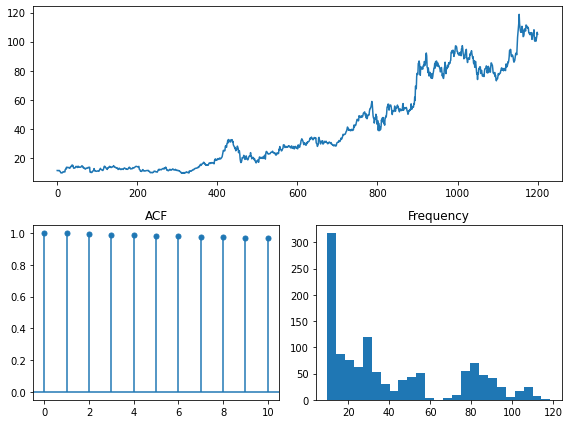

In [9]:
pm.tsdisplay(y_train, lag_max=10)

In [10]:
n_diffs = arima.ndiffs(y_train, max_d=5)

In [11]:
date_feat = preprocessing.DateFeaturizer(
    column_name='Date',  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)

_, X_train_feats = date_feat.fit_transform(y_train, X_train)

In [12]:
print(f"Head of generated X features:\n{repr(X_train_feats.head())}")

Head of generated X features:
   DATE-WEEKDAY-0  DATE-WEEKDAY-1  DATE-WEEKDAY-2  DATE-WEEKDAY-3  \
0               0               1               0               0   
1               0               0               1               0   
2               0               0               0               1   
3               0               0               0               0   
4               1               0               0               0   

   DATE-WEEKDAY-4  DATE-WEEKDAY-5  DATE-WEEKDAY-6  DATE-DAY-OF-MONTH  
0               0               0               0                  3  
1               0               0               0                  4  
2               0               0               0                  5  
3               1               0               0                  6  
4               0               0               0                  9  


In [13]:
pipe = pipeline.Pipeline([
    ('date', date_feat),
    ('arima', arima.AutoARIMA(d=n_diffs,
                              trace=3,
                              stepwise=True,
                              suppress_warnings=True,
                              seasonal=False))
])

pipe.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4394.724, Time=1.27 sec
First viable model found (4394.724)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4411.370, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4406.318, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4407.130, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4412.585, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4403.467, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4403.594, Time=1.00 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4395.784, Time=1.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4395.806, Time=2.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4402.749, Time=0.88 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4404.850, Time=1.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4405.128, Time=1.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4397.269, Time=2.25 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4396.085, Time=1.17 s

Pipeline(steps=[('date', DateFeaturizer(column_name='Date')),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

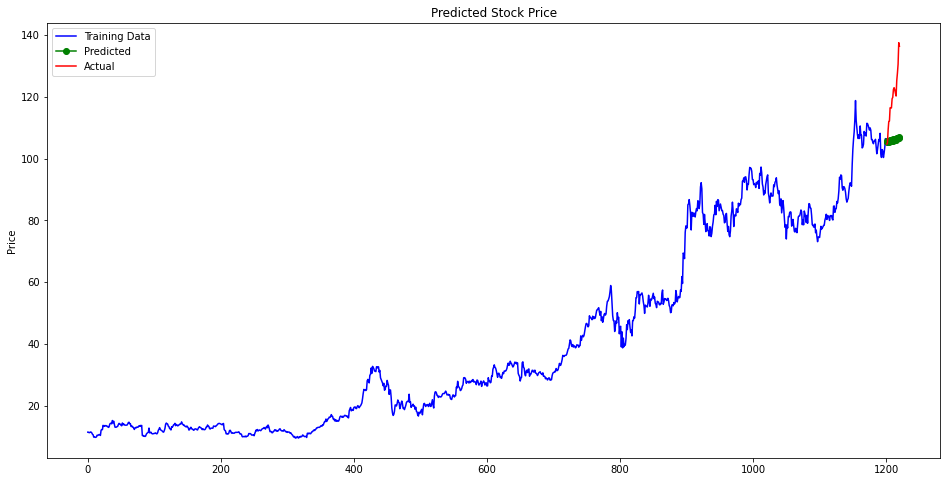

In [16]:
forecasts = pipe.predict(X=X_test)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)

n_train = y_train.shape[0]
x = np.arange(n_train + forecasts.shape[0])

ax.plot(x[:n_train], y_train, color='blue', label='Training Data')
ax.plot(x[n_train:], forecasts, color='green', marker='o',
        label='Predicted')
ax.plot(x[n_train:], y_test, color='red', label='Actual')
ax.legend(loc='upper left', borderaxespad=0.5)
ax.set_title('Predicted Stock Price')
ax.set_ylabel('Price')

plt.show()